![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#!pip install pandas==1.0.3

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,0,1,0
225,12493,2014,51330,0,0,0,1,0,0,0
270,7994,2007,116065,0,1,0,0,0,0,0


In [4]:
data.describe()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
count,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000,10495.000000
mean,14538.403716,2013.553883,52509.430395,0.056313,0.158456,0.012292,0.048213,0.236494,0.376370,0.111863
std,3922.420961,3.116585,36791.736601,0.230535,0.365186,0.110189,0.214227,0.424949,0.484498,0.315213
min,5002.000000,1998.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11999.000000,2012.000000,26461.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.000000,2014.000000,41680.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,16999.000000,2016.000000,71355.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,32444.000000,2018.000000,232658.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [5]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [6]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [7]:
# Celda 1
import math
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        n = len(y)
        r = y - mean()
        r = r ** 2
        r = np.sum(r)
        return r/n

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

def mse_split (X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    left_mean = np.mean(y_l)
    right_mean = np.mean(y_r)

    # Getting the left and right residuals 
    res_left = y_l - left_mean 
    res_right = y_r - right_mean

    # Concatenating the residuals 
    r = np.concatenate((res_left, res_right), axis=None)

    # Calculating the mse 
    n = len(r)
    r = r ** 2
    r = np.sum(r)
    mse_split = r / n
    return mse_split
    

# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            #gain = gini_impurity(X.iloc[:, j], y, split)
            mse = mse_split(X.iloc[:, j], y, split)
            
            if mse > best_split[2]:
                best_split = [j, split, mse]
    
    return best_split


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    #if X.shape[0] == 1:
    #    tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
    #    return tree
    
    # Calcular la mejor división
    j, split, mse = best_split(X, y, num_pct)
    
    #left_df, right_df = df[df[j]<=split].copy(), df[df[j]>split].copy()
    
    # Guardar el árbol y estimar la predicción
    #filter_l = j < split
    #y_l = y.loc[filter_l]
    y_pred = y.mean() 
    #y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    #tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], mse=mse)
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=mse) 
    # Revisar el criterio de parada 
    if mse < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

# Definición de parámetros y criterios de parada
max_depth = 5
num_pct = 10
max_features = None
min_gain=0.001

modelo = tree_grow(X_train, y_train, level=0, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
y_pred = tree_predict(X_test, modelo)

print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))

RMSE 3286.6987056698804
MAE 2629.174937481449


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [8]:
# Celda 2
MSE_scores = []
MAE_scores = []

n_samples = X_train.shape[0]
n_B = 10

samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

for i, sample in enumerate(samples):
    _X_train = X_train.iloc[sample, 1:]
    _y_train = y_train.iloc[sample]
    
    modelo = tree_grow(_X_train, _y_train, level=0, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    y_pred = tree_predict(X_test, modelo)
    
    MSE_scores.append(math.sqrt(mean_squared_error(y_test, y_pred)))
    MAE_scores.append(mean_absolute_error(y_test, y_pred))

print("RMSE", np.mean(MSE_scores))
print("MAE", np.mean(MAE_scores))

print()
print("listado de MAE", MAE_scores)


RMSE 6205.986438251428
MAE 5380.526496407133

listado de MAE [5631.609772493478, 5874.59479551082, 5099.768858253261, 4381.882048063727, 6379.968782278552, 6004.33585035117, 4982.090709363877, 4987.920265640373, 5545.358625206337, 4917.735256909733]


Para este caso el Bagging manual no obtuvo un buen resultado con respecto al arbol implementado en el punto anterior, el valor del RMSE del arbol fue: 3283.223494663697 contra el RMSE del bagging manual el cual alcanzo: 6375.119929123241, problema posiblemente casuado por el set de entrenamiento con reemplazo y la respectiva perdida de ejemplos.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [9]:
# Celda 3
from sklearn.ensemble import BaggingRegressor

n_features = data.shape[1]
modelo = BaggingRegressor(n_estimators=10, random_state=0, max_features=int(math.log(n_features)))
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))

RMSE 2354.448602808742
MAE 1827.342848084451


El desempeno del BaggingRegressor es bastante superior, al obtener un MAE de 1827.342848084451 versus un MAE 2629.174937481449 para el arbol de decision manual y un MAE de para el baggin manual.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [10]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

modelo = RandomForestRegressor(n_estimators=10, random_state=0, max_features=int(math.log(n_features)))
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))

RMSE 1839.2750402754596
MAE 1373.1188492292606


El desempeno del RandomForestRegressor es superior al BaggingRegressor al obtener un MAE de 1373.1188492292606 versus un MAE de 1827.342848084451, adicionalmente el RMSE 2354.448602808742 para BaggingRegressor es muy superior al RMSE 1839.2750402754596 del RandomForestRegressor. 

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Min MAE 1150.969194664488
Optimal depth 8


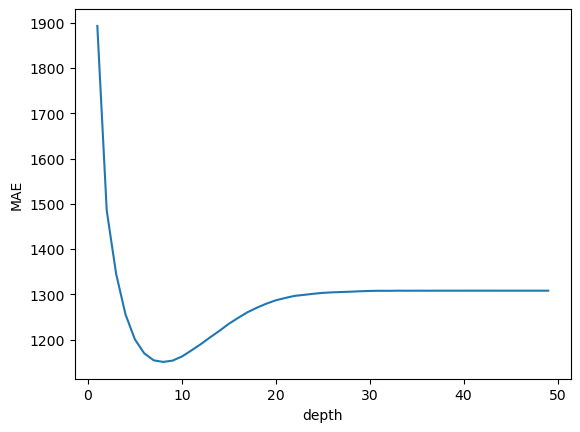

In [11]:
# Celda 5
import matplotlib.pyplot as plt

depth_range = range(1, 50)

MAE_scores = []
for depth in depth_range:
    modelo = RandomForestRegressor(n_estimators=200, max_depth=depth, random_state=0, n_jobs=-1)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    MAE_scores.append(mean_absolute_error(y_test, y_pred))
    
# Gráfica del desempeño del modelo vs la cantidad de feature
plt.plot(depth_range, MAE_scores)
plt.xlabel('depth')
plt.ylabel('MAE')

print("Min MAE", min(MAE_scores))
print("Optimal depth", depth_range[pd.Series(MAE_scores).idxmin()])

Min MAE 1308.231614952415
Optimal features 9


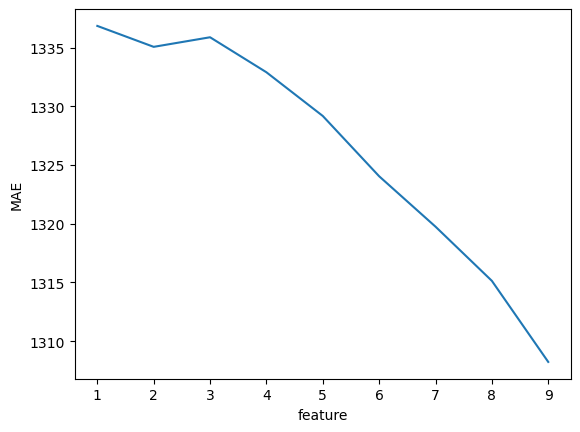

In [12]:
feature_range = range(1, n_features)

MAE_scores = []
for feature in feature_range:
    modelo = RandomForestRegressor(n_estimators=200, max_features=feature, random_state=0, n_jobs=-1)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    MAE_scores.append(mean_absolute_error(y_test, y_pred))
    
# Gráfica del desempeño del modelo vs la cantidad de feature
plt.plot(feature_range, MAE_scores)
plt.xlabel('feature')
plt.ylabel('MAE')

print("Min MAE", min(MAE_scores))
print("Optimal features", feature_range[pd.Series(MAE_scores).idxmin()])

Min MAE 1307.003725608094
Optimal estimator 130


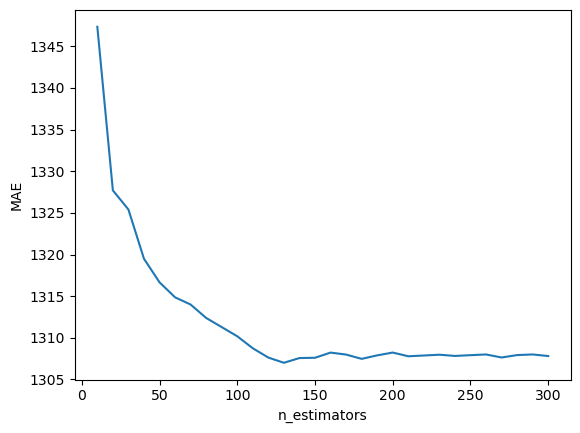

In [13]:
estimator_range = range(10, 310, 10)

MAE_scores = []
for estimator in estimator_range:
    modelo = RandomForestRegressor(n_estimators=estimator, random_state=0, n_jobs=-1)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    MAE_scores.append(mean_absolute_error(y_test, y_pred))
    
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, MAE_scores)
plt.xlabel('n_estimators')
plt.ylabel('MAE')

print("Min MAE", min(MAE_scores))
print("Optimal estimator", estimator_range[pd.Series(MAE_scores).idxmin()])

In [14]:
modelo = RandomForestRegressor(n_estimators=130, max_depth=8 ,random_state=0, max_features=9)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))

RMSE 1566.0559564550417
MAE 1151.2730646974967


El desempeno del RandomForestRegressor con los hiperparametros optimos n_estimators, max_depth y max_features; es muy superior al desempeno de los arboles anteriores, obteniendo un RMSE 1566.0559564550417 y un MAE 1151.2730646974967, valores muy inferiores.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [15]:
# Celda 6
import xgboost as xg

modelo = xg.XGBRegressor(objective='reg:squarederror', n_estimators=10, seed=0)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))

RMSE 1623.1341708729017
MAE 1186.5738254749747


Los valores obtenidos para el RMSE y MAE con la implementacion XGBRegressor son muy similares a los obtenidos para el RandomForestRegressor, siendo en este punto, mucho mejor el resulado del algoritmo RandomForestRegressor con los parametros optimos, para lo cual se obtiene un RMSE 1566.0559564550417 y un MAE 1151.2730646974967 

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Min MAE 1142.8158660959152
Optimal learning_rate 0.4


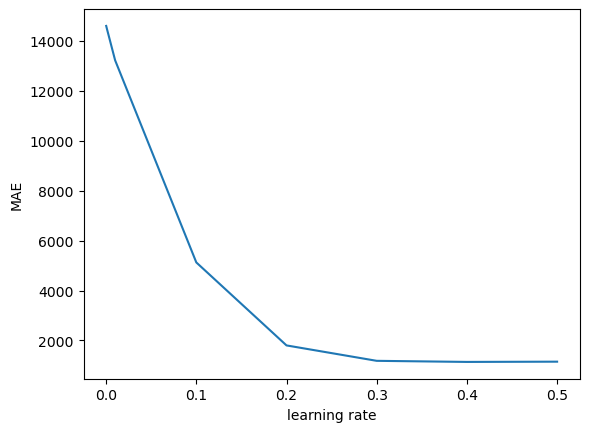

In [16]:
# Celda 7
learning_rate_range = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5]

MAE_scores = []
for p_learning_rate in learning_rate_range:
    modelo = xg.XGBRegressor(learning_rate=p_learning_rate, objective='reg:squarederror', n_estimators=10, seed=0)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    MAE_scores.append(mean_absolute_error(y_test, y_pred))
    
# Gráfica del desempeño del modelo vs la cantidad de feature
plt.plot(learning_rate_range, MAE_scores)
plt.xlabel('learning rate')
plt.ylabel('MAE')

print("Min MAE", min(MAE_scores))
print("Optimal learning_rate", learning_rate_range[pd.Series(MAE_scores).idxmin()])

Min MAE 1186.5738254749747
Optimal learning_rate 0


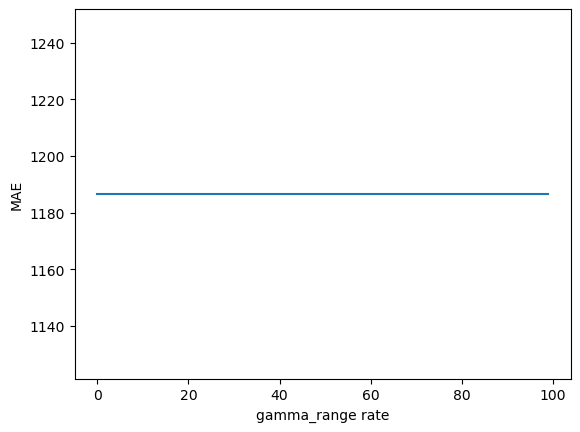

In [17]:
gamma_range = range(0, 100)

MAE_scores = []
for p_gamma in gamma_range:
    modelo = xg.XGBRegressor(gamma=p_gamma, objective='reg:squarederror', n_estimators=10, seed=0)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    MAE_scores.append(mean_absolute_error(y_test, y_pred))
    
# Gráfica del desempeño del modelo vs la cantidad de feature
plt.plot(gamma_range, MAE_scores)
plt.xlabel('gamma_range rate')
plt.ylabel('MAE')

print("Min MAE", min(MAE_scores))
print("Optimal learning_rate", gamma_range[pd.Series(MAE_scores).idxmin()])

Min MAE 1182.546630154581
Optimal colsample_bytree 0.9


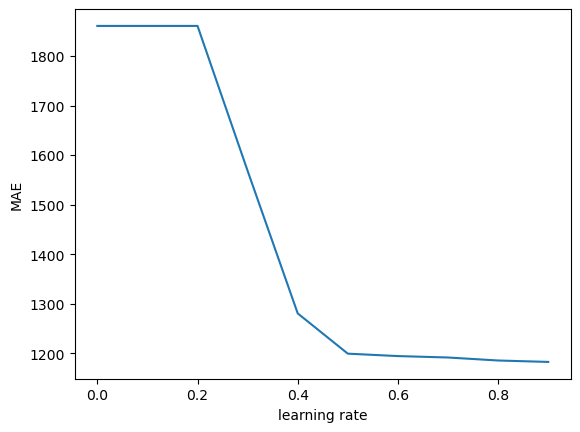

In [18]:
colsample_bytree_range = [x / 10 for x in range(0, 10, 1)]

MAE_scores = []
for p_colsample_bytree in colsample_bytree_range:
    modelo = xg.XGBRegressor(colsample_bytree=p_colsample_bytree, objective='reg:squarederror', n_estimators=10, seed=0)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    MAE_scores.append(mean_absolute_error(y_test, y_pred))
    
# Gráfica del desempeño del modelo vs la cantidad de feature
plt.plot(colsample_bytree_range, MAE_scores)
plt.xlabel('learning rate')
plt.ylabel('MAE')

print("Min MAE", min(MAE_scores))
print("Optimal colsample_bytree", colsample_bytree_range[pd.Series(MAE_scores).idxmin()])

In [19]:
modelo = xg.XGBRegressor(learning_rate=0.4, gamma=0, colsample_bytree=0.9, objective='reg:squarederror', n_estimators=10, seed=0)
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

print("RMSE", math.sqrt(mean_squared_error(y_test, y_pred)))
print("MAE", mean_absolute_error(y_test, y_pred))

RMSE 1555.5105859480598
MAE 1139.9572426881857


En la celda 7, estámos calibrando el parámetro learning_rate del  modelo XGBoost para regresión. 

LearningRate:
Probamos diferentes valores de learning_rate en el rango [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5] y evaluando el rendimiento del modelo en términos del error absoluto medio (MAE) en el conjunto de prueba para cada valor de learning_rate.
Después de probar todos los valores de learning_rate, graficamos el MAE en función del learning_rate y mostranos el valor mínimo de MAE  y el valor óptimo de learning_rate que produce el menor MAE se encuentra en 0.4.
Este parámetro controla el tamaño de los pasos que toma el algoritmo al actualizar los pesos del modelo. Un valor más bajo puede hacer que el modelo sea más robusto a la sobreajuste, pero también puede hacer que el entrenamiento sea más lento.

El gamma controla la complejidad del modelo al regular la reducción de pérdida requerida para dividir un nodo en un árbol. 
En el código se itera sobre un rango de valores gamma y ajusta el modelo con cada valor de gamma. 
Luego, se utiliza el modelo para predecir los valores en el conjunto de prueba y calcula el MAE para cada valor de gamma. 
Finalmente, se grafica el desempeño del modelo (MAE) en función del valor de gamma y se imprime el valor óptimo de gamma que minimiza el MAE.
Se observa que el valor óptimo del gamma es de cero.

El parámetro colsample_bytree controla la fracción de columnas que se muestrea al construir cada árbol. 
El código itera sobre un rango de valores para colsample_bytree y ajusta el modelo con cada valor. el valor optimo es de 0.9

Los valores obtenidos para el algoritmo XGBoost fueron RMSE 1623.1341708729017, MAE 1186.5738254749747; valores superiores a los obtenidos en la ejecucion del algoritmo con los mejores hiperparametros learning_rate, gamma, colsample_bytree, valores que corresponden a RMSE 1555.5105859480598 y MAE 1139.9572426881857.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

### Celda 8
Los valores obtenidos para el algoritmo de RandomForest con los hiperparametros optimos son muy similares a los obtenidos para el XGBoost con los parametros calibrados. Estos son  RMSE 1566.0559564550417 y MAE 1151.2730646974967 para RandomForest versus RMSE 1555.5105859480598 y MAE 1139.9572426881857 para XGBoost respectivamente.

El MAE del XGBoost es inferior en 12 unidades en comparacion con el MAE del RandomForest, por lo cual el rendimiento de ambos algoritmos calibrados es casi igual.